1. Import lib
2. Dataset
3. EDA
4. Text data processing
5. Transforming tokens to vectors
6. Text classification models - classifier

## **1. Import lib**

In [ ]:
import numpy as np
import pandas as pd

#Text Processing
import re
import string
import nltk
from nltk.corpus import stopwords

#sklearn
from sklearn import preprocessing, model_selection, decomposition, pipeline, metrics 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #for statistics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score

#pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings("ignore")

# **2.import Dataset**

In [ ]:
train = pd.read_csv("/content/train (1).csv")
test = pd.read_csv("/content/test (1).csv")

In [ ]:
train.shape,test.shape

((7613, 5), (3263, 4))

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# **3.EDA**

In [ ]:
#1. Missing Values

In [ ]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [ ]:
#Exploring the column - Target
#disaster -> predict its 1, not predict its 0

train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

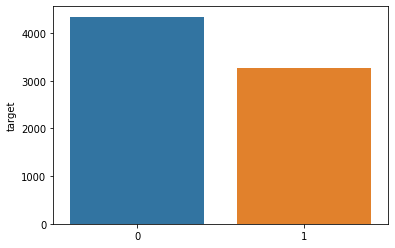

In [ ]:
sns.barplot(train['target'].value_counts().index,train['target'].value_counts())

In [ ]:
disaster_tweet = train[train['target'] == 1]['text']
non_disaster_tweet = train[train['target'] == 0]['text']

In [ ]:
disaster_tweet.values[1]

'Forest fire near La Ronge Sask. Canada'

In [ ]:
non_disaster_tweet.values[1]

'I love fruits'

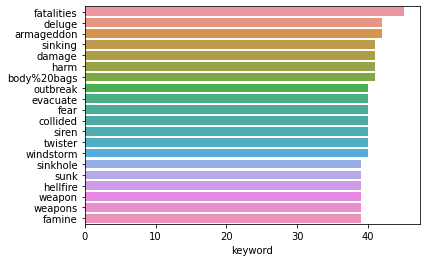

In [ ]:
#Exploring the column - keyword

sns.barplot(y= train['keyword'].value_counts()[:20].index, x=train['keyword'].value_counts()[:20])

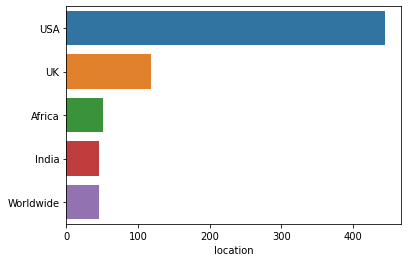

In [ ]:
#Exploring the column - location
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)
sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5])

# **4.Text PreProcessing**

In [ ]:
#1. Data Cleaning
# remove noise, Token, Stopwords
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train['text']=train['text'].apply(lambda x:clean_text(x))
test['text']=test['text'].apply(lambda x:clean_text(x))
train['text'][:5]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Text(0.5, 1.0, 'Non-Disaster Tweets')

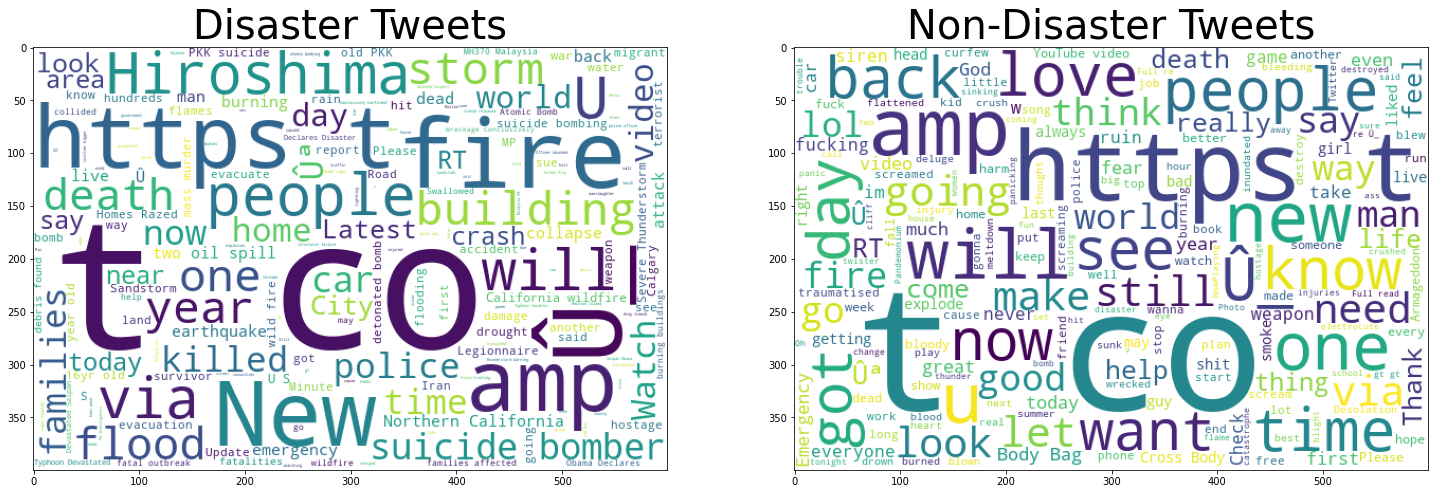

In [ ]:
import wordcloud
from wordcloud import WordCloud
fig,(ax1, ax2) = plt.subplots(1, 2, figsize =[25,10])
# ax1=> disaster_tweet

wordcloud1 = WordCloud(background_color= 'white',
                       width = 600,
                       height = 400).generate(" ".join(disaster_tweet))
ax1.imshow(wordcloud1)
ax1.set_title("Disaster Tweets", fontsize = 40)

#ax2 = > non_disaster_tweet
wordcloud2 = WordCloud(background_color= 'white',
                       width = 600,
                       height = 400).generate(" ".join(non_disaster_tweet))
ax2.imshow(wordcloud2)
ax2.set_title("Non-Disaster Tweets", fontsize = 40)


In [ ]:
# Tokenization 
text = "Are you going, aren't you"
token1 = nltk.tokenize.WhitespaceTokenizer()
token2 = nltk.tokenize.TreebankWordTokenizer()
token3 = nltk.tokenize.WordPunctTokenizer()
token4 = nltk.tokenize.RegexpTokenizer(r'\w+')
print("Example: ",text)
print("_____________________")

print("1. ",token1.tokenize(text))
print()
print("2. ",token2.tokenize(text))
print()
print("3. ",token3.tokenize(text))
print()
print("4. ",token4.tokenize(text))
print()

Example:  Are you going, aren't you
_____________________
1.  ['Are', 'you', 'going,', "aren't", 'you']

2.  ['Are', 'you', 'going', ',', 'are', "n't", 'you']

3.  ['Are', 'you', 'going', ',', 'aren', "'", 't', 'you']

4.  ['Are', 'you', 'going', 'aren', 't', 'you']



In [ ]:
tokens = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokens.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokens.tokenize(x))

In [ ]:
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#3. Stopwords
# nltk.download('stopwords')
def remove_stopwords(text):
  words = [w for w in text if w not in stopwords.words('english')]
  return words
train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# 4.Noramlization
# stemming, Lemmatization 

# we are not going to do normalization bcs we are going to classify the not the reteriving
# just doing it for understanding below
teext = "feet cats wolves talked"

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokenss = tokenizer.tokenize(teext)

#stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming of the input text: "," ".join(stemmer.stem(token) for token in tokenss))

#lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
print("Lemmatizing the input text: "," ".join(lemmatizer.lemmatize(token) for token in tokenss))

Stemming of the input text:  feet cat wolv talk
Lemmatizing the input text:  foot cat wolf talked


In [ ]:
def combine_text (list_text):
  combined_text = " ".join(list_text)
  return combined_text

train['text'] = train['text'].apply(lambda x: combine_text (x))
test['text'] = test['text'].apply(lambda x: combine_text (x))

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [ ]:
# Getting it all together
def text_preprocess(text):
  tokenize =  nltk.tokenize.RegexpTokenizer(r'\w+')
  clean_data = clean_text(text)
  tokenized_text = tokenizer.tokenize(clean_data)
  remove_stopwords = [w for w in tokenized_text if w not in stopwords.word('english')]
  combined_text = " ".join(remove_stopwords)
  return combined_text

# **5.Transforming tokens to vector**

In [ ]:
# 1. Bag of Words

In [ ]:
# Countvector

count_vectorizer = CountVectorizer()
train_vector = count_vectorizer.fit_transform(train["text"])
test_vector = count_vectorizer.transform(test['text'])

print(train_vector[0].todense()) #to dense() --> array to dense(in depth format) or matrix format

[[0 0 0 ... 0 0 0]]


In [ ]:
#fit()
#transform()
#fit_tranform()

In [ ]:
#tf-idf vectorization
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range = (1,2)) # ngram_range(tfidf value, product of tf and idf)

train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test['text'])

**6.Building Text Classification - Model**

**Logistic Regression**

In [ ]:
#Logistic
clf = LogisticRegression(C=1.0)
# C is the inverse of regularization Strength (default value is 1)...
# if this c is decreasing then regulariztion will be increasing...
# if regularization increase then leads to overfitting...
scores = model_selection.cross_val_score(clf, train_vector, train['target'], cv = 5, scoring = 'f1')
# cv (cross validation) which returns the probablity form of distribution models
scores
# process of applying the algorithemic model which build from the historical data set.
# here our historical data is train_vector.
# our algo is logistic.

array([0.59865255, 0.49611063, 0.57166948, 0.56290774, 0.68789809])

In [ ]:
clf.fit(train_vector,train["target"])

LogisticRegression()

In [ ]:
#tfidf
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train['target'], cv = 5, scoring = 'f1')
scores

array([0.57229525, 0.49673203, 0.54277829, 0.46618106, 0.64768683])

**Naives Bayes**

In [ ]:
# Naives Bayes
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vector, train['target'], cv = 5, scoring = 'f1')
scores

array([0.63149079, 0.60675773, 0.68575519, 0.64341085, 0.72505092])

In [ ]:
#tfidf
clf_NB_tfidf = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_tfidf, train_tfidf, train['target'], cv = 5, scoring = 'f1')
scores

array([0.57590597, 0.57092511, 0.61135371, 0.5962963 , 0.7393745 ])

**Extreme Gradient Boosting(XGB)**

In [ ]:
#XGBoost
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(max_depth = 7, n_estimators = 200, colsample_bylevel = 0.8, subsample = 0.8 ,nthread = 10, learning_rate = 0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vector, train['target'], cv = 5, scoring = 'f1')
scores

array([0.47379913, 0.36275461, 0.43454039, 0.38085106, 0.52173913])

In [ ]:
clf_xgb_tfidf = xgb.XGBClassifier(max_depth = 7, n_estimators = 200, colsample_bylevel = 0.8, subsample = 0.8 ,nthread = 10, learning_rate = 0.1)
scores = model_selection.cross_val_score(clf_xgb_tfidf, train_tfidf, train['target'], cv = 5, scoring = 'f1')
scores

array([0.48612653, 0.35785288, 0.42722117, 0.41386555, 0.52601156])